## Fraud Detection
In this project, our goal is to construct a predictive model that can identify potentially fraudulent transactions for a financial organization. The insights derived from the model's analysis will be utilized to formulate a practical and effective strategy.

### Dataset Overview

In this project, we utilize a comprehensive dataset specifically curated for detecting fraudulent transactions.

The dataset is apparently generated using PaySim, a mobile money simulator that closely models real-world transactions. The dataset contains over 6 million transactions, each of which is described by 11 features. The features are as follows:
* `step`: the unit of time in real-world seconds.
* `type`: the type of transaction, which can be one of the following:
    *    `CASH-IN`,
    *    `CASH-OUT`,
    *    `DEBIT`,
    *    `PAYMENT`,
    *    `TRANSFER`.
* `amount`: the amount of the transaction in local currency.
* `nameOrig`: the customer who initiated the transaction.
* `oldbalanceOrg`: the customer's balance before the transaction.
* `newbalanceOrig`: the customer's balance after the transaction.
* `nameDest`: the recipient ID of the transaction.
* `oldbalanceDest`: the recipient's balance before the transaction.
* `newbalanceDest`: the recipient's balance after the transaction.
* `isFraud`: whether the transaction is fraudulent or not.
* `isFlaggedFraud`: whether the transaction is flagged as fraudulent by the system.

Reference :
<br>PaySim research paper
<br>*E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016*

### Libraries

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
# from google.colab import drive

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#Misc libraries
import random
import warnings
warnings.filterwarnings("ignore")

### Data Acquisition

In [2]:
# importing the dataset

# drive.mount('/content/drive')
frd = pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")
frd.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Exploratory Data Analysis

In [3]:
print("No. of records:",frd.shape[0])
print("No. of features:",frd.shape[1])

No. of records: 6362620
No. of features: 11


In [4]:
frd.isnull().values.any()

False

The dataset contains no missing values.

In [5]:
frd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Here we know Column Name `type` is categorical data,

And `nameOrig` and `nameDest` is user specific object data.

Also the memory usage is 534.0+ MB

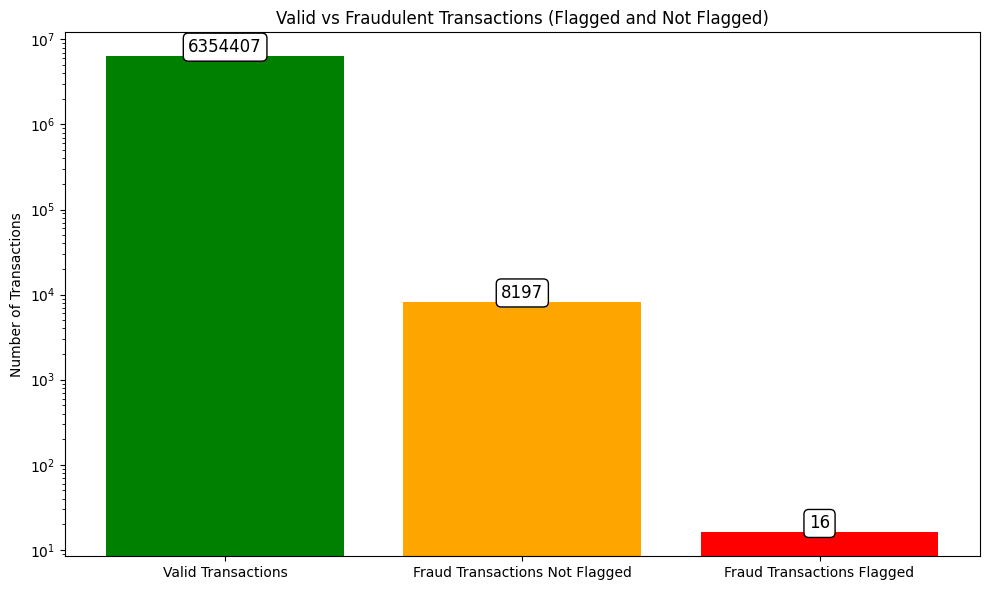

In [6]:
# Copying your data to a new DataFrame for safety
data = frd.copy()

# Get the counts for valid, fraudulent transactions, flagged and not flagged transactions
valid_transactions_count = data['isFraud'].value_counts()[0]
fraud_transactions_count = data['isFraud'].value_counts()[1]
flagged_fraud_count = data['isFlaggedFraud'].value_counts()[1]
not_flagged_fraud_count = fraud_transactions_count - flagged_fraud_count

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(['Valid Transactions', 'Fraud Transactions Not Flagged', 'Fraud Transactions Flagged'],
              [valid_transactions_count, not_flagged_fraud_count, flagged_fraud_count],
              color=['green', 'orange', 'red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval),
             ha='center', va='bottom', color='black',fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.ylabel('Number of Transactions')
plt.title('Valid vs Fraudulent Transactions (Flagged and Not Flagged)')
plt.yscale('log')  # Log scale to better visualize differences in count
plt.tight_layout()
plt.show()

As is evident fromt he graph the middle bar is about the Fraud Transactions which were not flagged which is way high than the ones those were flagged.

> **Note**
><br> Here we have used log scale to plot the graph because the bar 2 and 3 wont we visible when plotted with 6 million scale of value in bar 1

In [7]:
#To check which type of transaction are actually fraud
print(list(data.loc[data.isFraud == 1].type.drop_duplicates().values))

['TRANSFER', 'CASH_OUT']


Going deeper into the Fradulent transactions, we find that there are only two types, Transfer and Cash Out type.
<br>One can infer that, fradulent transactions involve transfering the amount from one account and then using the another account to withraw it in cash form.

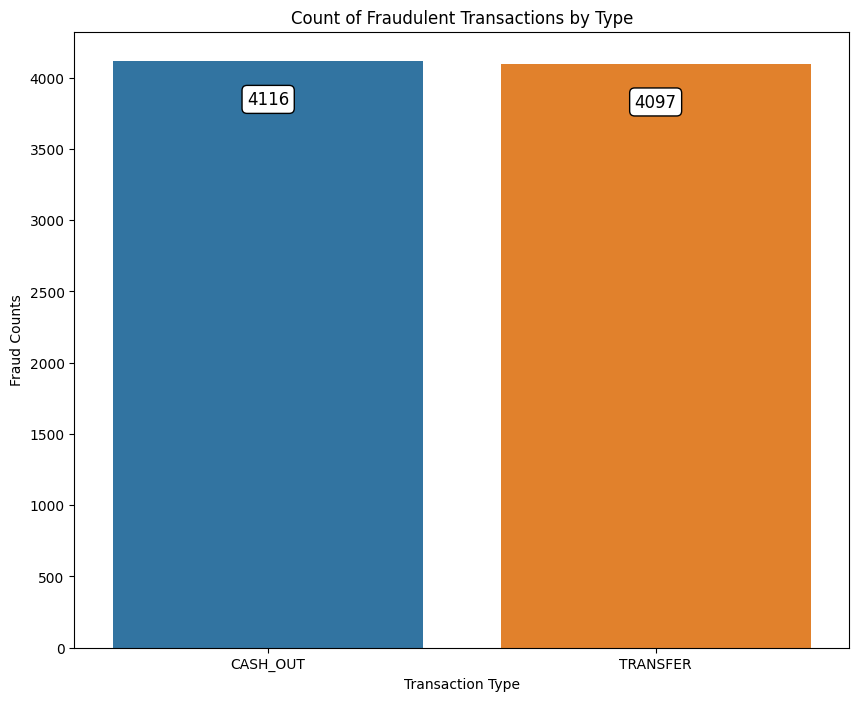

In [8]:
# Group fraudulent transactions by type
fraud_counts = data[data['isFraud'] == 1].groupby('type').size().reset_index(name='Counts')
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='type', y='Counts', data=fraud_counts, palette='tab10')
for index, row in fraud_counts.iterrows():
    bar_height = row['Counts']
    bar_position = barplot.patches[index].get_x() + barplot.patches[index].get_width() / 2
    vertical_position = bar_height - (0.05 * bar_height)
    plt.text(bar_position, vertical_position, s=row['Counts'],
             ha='center', va='top', color='black', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Counts')
plt.title('Count of Fraudulent Transactions by Type')
plt.show()


Since there are only two types of transactions that have fraud we can remove the other types of transactions. We also

In [9]:
data = data.loc[(data['type'].isin(['TRANSFER', 'CASH_OUT']))]
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [10]:
fraud = data[data["isFraud"] == 1]
fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]
fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

Here, we can see that when amount is transferred to a particular account, that account is not used for cashing out.
Taking this into conisderation we can drop the nameOrig and nameDest.

In [11]:
names = ["nameOrig","nameDest"]
data = data.drop(columns=names)

In [12]:
#Checking for balance descrepancies
oldgiver = sum(data["amount"] > data["oldbalanceOrg"])
print("No. of Transactions when outgoing amount higher than balance of self: ",
      oldgiver)
newreceiver = sum(data["amount"] > data["newbalanceDest"])
print("No. of Transactions when incoming amount higher than balance of sender: ",
      newreceiver)

No. of Transactions when outgoing amount higher than balance of self:  2488634
No. of Transactions when incoming amount higher than balance of sender:  36802


From this we can say that a lot of transactions have error in balance and it can be a good feature to train on

In [13]:
#Introducing a new feature
data['errorBalanceOrig'] = data.newbalanceOrig + data.amount - data.oldbalanceOrg
data['errorBalanceDest'] = data.oldbalanceDest + data.amount - data.newbalanceDest

In [14]:
# data.replace(to_replace = ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'], value = [1,2,3,4,5],inplace = True)
#Replacing the Transfer and Cashout string with integer values
data.replace(to_replace = ['TRANSFER', 'CASH_OUT'], value = [1,2],inplace = True) # Can be removed
#Removing isFlaggedFraud since it has significance in training
data = data.drop(columns = "isFlaggedFraud")
data.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
2,1,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0
3,1,2,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0
15,1,2,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0


## Pre-processing Data

### Balancing the data

In [15]:
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=data['isFraud'].value_counts())])
fig.show()


It is evident the dataset is not balanced, and is thus insufficient for machine to learn. To solve this we balance the dataset

In [16]:
#Getting the max size
max_size = data['isFraud'].value_counts().max()
lst = [data]
for class_index, group in data.groupby('isFraud'):
    lst.append(group.sample(max_size-len(group), replace=True))
data = pd.concat(lst)

In [17]:
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'],
                             values=data['isFraud'].value_counts())])
fig.show()

> Reference taken from https://www.kaggle.com/code/benroshan/transaction-fraud-detection

### One hot encoding

In [18]:
#Using One hot encoding based on 'type'
data = pd.get_dummies(data,prefix=['type'],columns=['type'])

In [19]:
pd.DataFrame.head(data)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,type_1,type_2
2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,True,False
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,False,True
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,False,True
19,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,True,False
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,True,False


### Data Splitting & Normalizing

In [20]:
#
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [21]:
X = data.drop(columns = "isFraud")
y = data.isFraud
# Test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Normalizing
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Creating the model objects
logreg_cv = LogisticRegression(solver='liblinear', random_state=524)
dt_cv = DecisionTreeClassifier(random_state=524)
knn_cv = KNeighborsClassifier()
# svc_cv = SVC(kernel='linear', random_state=524)
nb_cv = GaussianNB()
rf_cv = RandomForestClassifier(random_state=524)

# Dictionary of models
cv_dict = {
    0: 'Logistic Regression',
    1: 'Decision Tree',
    2: 'KNN',
    3: 'Naive Bayes',
    4: 'Random Forest'
}

cv_models = [logreg_cv, dt_cv, knn_cv, nb_cv, rf_cv]

# Evaluate each model using cross-validation
for i, model in enumerate(cv_models):
    cv_score = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print("{} Test Accuracy: {:.2f}%".format(cv_dict[i], cv_score.mean() * 100))

Logistic Regression Test Accuracy: 91.87%
Decision Tree Test Accuracy: 100.00%
KNN Test Accuracy: 99.91%
Naive Bayes Test Accuracy: 74.24%
Random Forest Test Accuracy: 100.00%


KeyboardInterrupt: 



1. **Logistic Regression** - Good baseline linear model for binary classification tasks.
2. **Decision Tree** - A non-linear model that is easy to interpret.
3. **K-Nearest Neighbors (KNN)** - A non-parametric method that can capture complex decision boundaries.
4. **Naive Bayes** - Based on Bayes’ theorem with an assumption of independence among predictors. It performs well in the case of categorical input variables compared to numerical variables.
5. **Random Forest** - An ensemble method that operates by constructing a multitude of decision trees. It's generally robust and can handle a variety of data types.

>Reference Taken from Analytics Vidhya & ChatGPT



## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}

rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=524),
                                       param_distributions=rf_param_grid,
                                       n_iter=10,
                                       cv=5,
                                       verbose=2,
                                       random_state=524,
                                       n_jobs=-1,
                                       scoring='accuracy')

rf_random_search.fit(X_train, y_train)
print("Best Parameters for Random Forest:", rf_random_search.best_params_)
print("Best Score for Random Forest: {:.2f}%".format(rf_random_search.best_score_ * 100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Since we are getting 100% accuracy there is a case of overfitting, to improve that we need hyperparameter tuning, but instead of Grid Search we implement Random Search.

## Feature importance analysis

In [ ]:
best_rf_model = rf_random_search.best_estimator_
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(15, 5))
plt.title("Feature Importance - Tuned Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

As is evident from the graph, the importance of features is exhibited in descending order.
The arrangement of features is determined by the count of samples influenced by divisions made along these features.

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
disp = plot_confusion_matrix(best_rf_model, X_test, y_test,
                             display_labels=['Not Fraud', 'Fraud'],
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion Matrix - Random Forest")
plt.show()


The model has detected some false positives, but crucially, it has not allowed a single false negative, which is more significant in this context. 
Given that overlooking a fraudulent transaction is unacceptable, we prioritize avoiding false negatives. 
A preventive measure to update the model and keep track of descrepancies in balance of users. The company can introduce a flagging system so they can keep track of a situation when it arises and contact the client or put a hold on their account for the same.  

To analyse that these actions are working as expected after implementation, a further analysis would give a better picture. The model can be implemented in real time to keep track of transaction data being generated and updating the model to detect and report. 